## Initialize

In [1]:
%matplotlib inline

import pickle, os, sys

import numpy as np
import random

from librosa import zero_crossings, power_to_db
from librosa.feature import melspectrogram, mfcc

from deap import creator, gp, base, tools
import librosa

import yaml

import matplotlib.pyplot as plt
import pygraphviz as pgv
plt.ion()

from ipywidgets import interactive, interact
import ipywidgets as widgets
import IPython.display as ip_disp
from  IPython.display import HTML

# Necessary to be able to import code from the main Python files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from gensynth.supercollider.representation import get_primitive_set, available_ugens
from gensynth.supercollider.synthesis import initialize_synthesis_dirs
from gensynth.supercollider.fitness import reevaluate_individuals

initialize_synthesis_dirs()

In [2]:
primitive_set = get_primitive_set()

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, pset=primitive_set)

toolbox = base.Toolbox()
toolbox.register(
    "generateSynthTree",
    gp.genGrow,
    pset=primitive_set,
    min_=1,
    max_=3
)

# Create an individual generating function that is a synth definition tree
toolbox.register("individual", tools.initIterate, container=creator.Individual, generator=toolbox.generateSynthTree)

# Create a population function that generates a list of n individuals using the individual() function.
toolbox.register("population", tools.initRepeat, container=list, func=toolbox.individual)

In [3]:
# Workaround for being able to generate synth sounds from within Jupyter
import nest_asyncio
nest_asyncio.apply()

## Define audios

In [4]:
label_audio_name = "synthetic/multiple_oscillations"
sample_rate = 44100
duration = 0.1

label_audio_path = "../sounds/" + label_audio_name + ".aiff"
label_audio, _ = librosa.load(label_audio_path, sr=sample_rate)

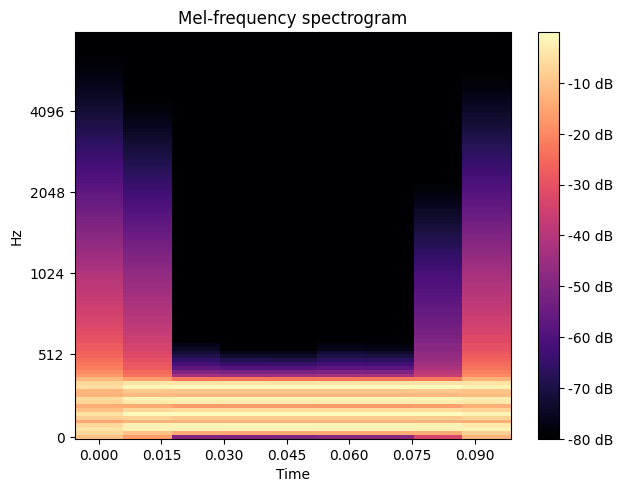

In [5]:
audio_widget = ip_disp.Audio(
    data=label_audio, 
    rate=sample_rate
)
display(audio_widget)

mel_spectrogram_label = librosa.feature.melspectrogram(y=label_audio, sr=sample_rate)
mel_spectrogram_decibel_label = librosa.power_to_db(mel_spectrogram_label, ref=np.max)
figure, ax = plt.subplots()
img = librosa.display.specshow(
    mel_spectrogram_decibel_label,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=8000,
    ax=ax
)
figure.colorbar(img, ax=ax, format='%+2.0f dB')
plt.tight_layout()
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [6]:
individual_count = 3
individuals = toolbox.population(n=individual_count)

In [7]:
reevaluate_individuals(individuals, label_audio, primitive_set, duration, sample_rate, fitness_config={'distance': 'l1', 'feature': 'mel_db'}, helper_objective="mfcc", sc_executable_path="../SuperCollider/installation/bin/scsynth")

-- Generating Audio
-- Computing Losses


In [8]:
all_audios = [label_audio]
all_audios.extend([ind.audio for ind in individuals])

In [16]:
def compute_zero_crossing_histogram(audio):
    crossing_mask = librosa.zero_crossings(audio)
    # TODO: Find the correct min/max interval range and a good number of bins (possibly a hyperparameter)
    intervals = (np.diff(np.where(crossing_mask == 1)) - 1)[0]
    plt.hist(intervals, bins=50, range=(0, 1100))
    plt.show()

In [17]:
def display_audios(audios):
    solution_widgets = []
    for index, audio in enumerate(audios):
        solution_widget = widgets.Output()
        with solution_widget:
            audio_widget = ip_disp.Audio(
                data=audio, 
                rate=sample_rate
            )
            display(audio_widget)
            
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
            mel_spectrogram_decibel = librosa.power_to_db(mel_spectrogram, ref=np.max)
            figure, ax = plt.subplots()
            img = librosa.display.specshow(
                mel_spectrogram_decibel,
                x_axis='time',
                y_axis='mel',
                sr=sample_rate,
                fmax=8000,
                ax=ax
            )
            figure.colorbar(img, ax=ax, format='%+2.0f dB')
            plt.tight_layout()
            ax.set(title='Mel-frequency spectrogram')
            plt.show()

            histogram_widget = widgets.Output()
            with histogram_widget:
                compute_zero_crossing_histogram(audio)
            display(histogram_widget)
            
            #display(str(individual))
            
        solution_widgets.append(solution_widget)
    
    all_audios = widgets.HBox(solution_widgets)
    display(all_audios)

In [18]:
display_audios(all_audios)

In [12]:
zero_crossings_per_period = 2
lowest_audible_frequency = 20 #Hz
lowest_zero_crossings_per_second = zero_crossings_per_period * lowest_audible_frequency
longest_possible_interval = sample_rate / lowest_zero_crossings_per_second
print(longest_possible_interval)

1102.5


In [13]:
from scipy.spatial import distance as dst

In [14]:
example_base = np.array([1, 0, 0])
example_1 = np.array([0, 1, 0])
example_2 = np.array([0, 0, 1])

In [15]:
covariance = np.array([
    [1, 0.5, 0.25],
    [0.5, 1, 0],
    [0.25, 0, 1]
])
cov_inv = np.linalg.inv(covariance)
print(cov_inv)
print(dst.mahalanobis(example_base, example_base, cov_inv))
print(dst.mahalanobis(example_base, example_1, cov_inv))
print(dst.mahalanobis(example_base, example_2, cov_inv))

print(dst.mahalanobis(example_1, example_2, cov_inv))
print(dst.mahalanobis(np.array([1, 0, 1]), np.array([2, 0, 5]), cov_inv))

[[ 1.45454545 -0.72727273 -0.36363636]
 [-0.72727273  1.36363636  0.18181818]
 [-0.36363636  0.18181818  1.09090909]]
0.0
2.0670576365276494
1.8090680674665818
1.4459976109624424
4.0


Conclusion: Getting a proper histogram similarity measure is hard, an okay approximation for right now is using larger buckets.